In [1]:
%matplotlib inline

# Training Data Summary

In [2]:
import os
import re
import math

from collections import namedtuple, Counter
from glob import glob
from multiprocessing import Pool, freeze_support

import numpy as np
import scipy
import wfdb

from biosppy.signals.ecg import ecg
from matplotlib import pyplot as plt
from matplotlib import gridspec as gridspec
from tqdm.notebook import tqdm
from wfdb import processing

## Initial Data

The [data for this Challenge](https://physionetchallenges.github.io/2020/#-data) comes from multiple sources:

1. Southeast University, China, including the data from the China Physiological Signal Challenge 2018
2. Centre for Cardiometabolic Risk Reduction in South-Asia (CARRS), India
3. A diverse population in the USA.

This full dataset has not been released yet.
The initial data provided is the public data used in the [China Physiological Signal Challenge in 2018 (CPSC2018)](http://2018.icbeb.org/).
It contains:

* 6,877 records (male: 3,699, female: 3,178)
* 12-lead ECG recordings ranging from 6 to 60 seconds
* Sampled at 500Hz
* Age, Diagnosis at the end of header file


In [3]:
record_names = tuple(sorted(fn.split(".hea")[0] for fn in glob("Training_WFDB/*.hea")))
num_records = len(record_names)
print("num records:", num_records)


num records: 6877


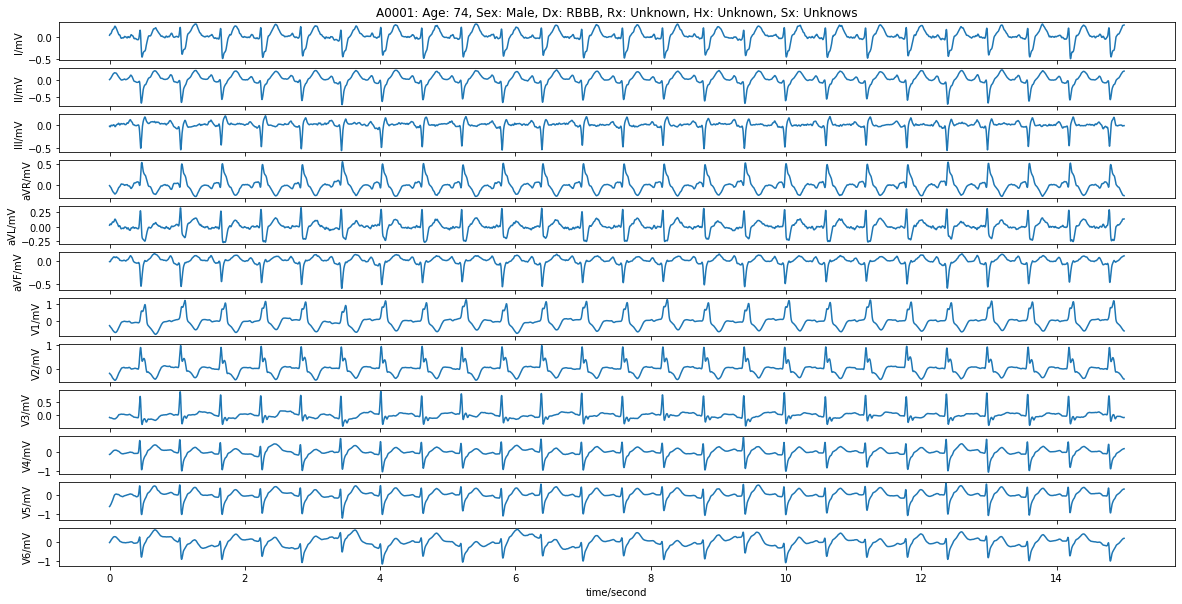

record_name: A0001
n_sig: 12
fs: 500
counter_freq: None
base_counter: None
sig_len: 7500
base_time: 00:00:05
base_date: None
comments: ['Age: 74', 'Sex: Male', 'Dx: RBBB', 'Rx: Unknown', 'Hx: Unknown', 'Sx: Unknows']
sig_name: ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
p_signal: [[ 0.028  0.007 -0.021 ... -0.112 -0.596 -0.016]
 [ 0.039  0.011 -0.028 ... -0.11  -0.59  -0.007]
 [ 0.045  0.015 -0.03  ... -0.108 -0.582  0.002]
 ...
 [ 0.258  0.248 -0.01  ...  0.194  0.307  0.213]
 [ 0.259  0.249 -0.01  ...  0.194  0.307  0.214]
 [ 0.259  0.25  -0.009 ...  0.195  0.307  0.214]]
d_signal: None
e_p_signal: None
e_d_signal: None
file_name: ['A0001.mat', 'A0001.mat', 'A0001.mat', 'A0001.mat', 'A0001.mat', 'A0001.mat', 'A0001.mat', 'A0001.mat', 'A0001.mat', 'A0001.mat', 'A0001.mat', 'A0001.mat']
fmt: ['16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16']
samps_per_frame: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
skew: [None, None, None, None, None, N

In [4]:
# show what one record looks like
record = wfdb.rdrecord(record_names[0])
wfdb.plot_wfdb(
    record=record, figsize=(20,10),
    time_units="seconds", title="{}: {}".format(record.record_name, ", ".join(record.comments)))
for k, v in record.__dict__.items():
    print(f"{k}: {v}")

## Initial Data Distribution

In [5]:
Meta = namedtuple("Meta", ("duration", "age", "sex", "Dx"))
labels = ("Normal", "AF", "I-AVB", "LBBB", "RBBB", "PAC", "PVC", "STD", "STE")

def derive_meta(rn):
    r = wfdb.rdrecord(rn)
    key = r.record_name

    # data hygiene, check match challenge description
    assert len(r.p_signal) == r.sig_len, f"{key} sig_len mismatch"
    assert r.n_sig == 12, f"{key} n_sig not 12-lead"
    assert all(len(l) == r.n_sig for l in r.p_signal), f"{key} p_signal not 12-lead"
    assert r.fs == 500, f"{key} not 500Hz"
    assert r.sig_name == ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    assert r.fmt == ['16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16']
    assert r.samps_per_frame == [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
    assert r.skew == [None, None, None, None, None, None, None, None, None, None, None, None]
    assert r.byte_offset == [24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]
    assert r.adc_gain == [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]
    assert r.baseline == [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    assert r.units == ['mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV']
    assert r.adc_res == [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
    assert r.adc_zero == [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    assert r.block_size == [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

    # parse out age, sex, diagnosis from comments
    assert len(r.comments) == 6, f"{key} header comments invalid"
    raw_age, raw_sx, raw_dx, _rx, _hx, _sx = r.comments
    age_grp = re.search(r"^Age: (?P<age>.*)$", raw_age)
    assert age_grp is not None, f"{key} no age defined: {raw_age}"
    age = float(age_grp.group("age"))
    if math.isnan(age):
        age = -1

    sx_grp = re.search(r"^Sex: (?P<sx>.*)$", raw_sx)
    assert sx_grp is not None, f"{key} no sex defined: {raw_sx}"
    sex = sx_grp.group("sx")
    assert sex in ("Male", "Female"), f"{key} not male/female: {sex}"
    dx_grp = re.search(r"^Dx: (?P<dx>.*)$", raw_dx)
    assert dx_grp is not None, f"{key} no Dx defined: {raw_dx}"
    dx = dx_grp.group("dx").split(",")
    assert all(d in labels for d in dx), f"{key} label mismatch: {dx}"

    duration = r.sig_len/r.fs

    return key, Meta(duration, age, sex, dx)


In [6]:
metas = {}
# single process approach
# for record_name in tqdm(record_names, desc="Record"):
#     key, meta = derive_meta(record_name)
#     metas[key] = meta

# multiprocess approach
try:
    procs = len(os.sched_getaffinity(0))
except:
    procs = 1

with tqdm(record_names, desc="Record") as t:
    with Pool(procs, initializer=tqdm.set_lock,
              initargs=(tqdm.get_lock(),)) as p:
        metas = dict(p.imap_unordered(derive_meta, t))


### ECG Recording Lengths

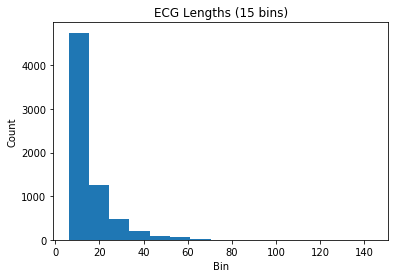

  6.0s: 4746 records
 15.2s: 1259 records
 24.4s: 466 records
 33.6s: 212 records
 42.8s: 95 records
 52.0s: 73 records
 61.2s: 9 records
 70.4s: 5 records
 79.6s: 2 records
 88.8s: 2 records
 98.0s: 2 records
107.2s: 1 records
116.4s: 2 records
125.6s: 1 records
134.8s: 2 records


In [7]:
bins = 15
plt.title(f"ECG Lengths ({bins} bins)")
plt.xlabel("Bin")
plt.ylabel("Count")

durations = [m.duration for m in metas.values()]
count_vals, bin_vals, _ = plt.hist(durations, bins=bins)

plt.show()

for k, v in zip(bin_vals, count_vals):
    # plt.text(k, v, "{:.1f}s: {:.0f}".format(k, v))
    print("{:>5.1f}s: {:.0f} records".format(k, v))

# for full resolution, fine grained
# counts = Counter(durations)
# x = list(counts.keys())
# y = list(counts.values())
# plt.scatter(x, y)

### ECG Recording Patient Age

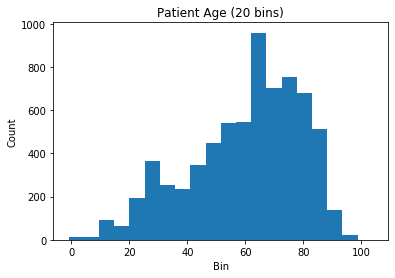

-1 yrs: 13 records
 4 yrs: 11 records
10 yrs: 91 records
15 yrs: 62 records
20 yrs: 192 records
25 yrs: 365 records
30 yrs: 254 records
36 yrs: 234 records
41 yrs: 348 records
46 yrs: 447 records
52 yrs: 542 records
57 yrs: 546 records
62 yrs: 959 records
67 yrs: 702 records
72 yrs: 755 records
78 yrs: 681 records
83 yrs: 513 records
88 yrs: 140 records
94 yrs: 21 records
99 yrs: 1 records


In [8]:
bins = 20
plt.title(f"Patient Age ({bins} bins)")
plt.xlabel("Bin")
plt.ylabel("Count")

ages = [m.age for m in metas.values()]
count_vals, bin_vals, _ = plt.hist(ages, bins=bins)

plt.show()

for k, v in zip(bin_vals, count_vals):
    # plt.text(k, v, "{:.1f}s: {:.0f}".format(k, v))
    print("{:>2.0f} yrs: {:.0f} records".format(k, v))

# for full resolution, fine grained
# counts = Counter(ages)
# x = list(counts.keys())
# y = list(counts.values())
# plt.scatter(x, y)

### ECG Diagnosis Distribution

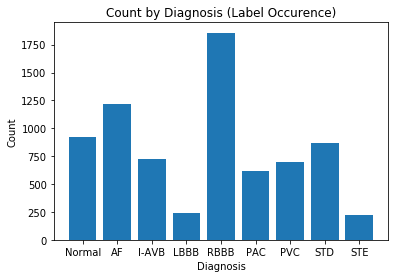

Label Occurences
Normal: (13.3%) 918 records
    AF: (17.8%) 1221 records
 I-AVB: (10.5%) 722 records
  LBBB: ( 3.4%) 236 records
  RBBB: (27.0%) 1857 records
   PAC: ( 9.0%) 616 records
   PVC: (10.2%) 700 records
   STD: (12.6%) 869 records
   STE: ( 3.2%) 220 records


In [9]:
flat_dx = [dx for m in metas.values() for dx in m.Dx]
dx_counter = Counter(flat_dx)

plt.title("Count by Diagnosis (Label Occurence)")
plt.xlabel("Diagnosis")
plt.ylabel("Count")
plt.bar(labels, list(dx_counter[l] for l in labels))
bottom, top = plt.ylim()
plt.show()

print("Label Occurences")
for label in labels:
    pct = 100 * dx_counter[label] / num_records
    print("{:>6}: ({:>4.1f}%) {} records".format(label, pct, dx_counter[label]))

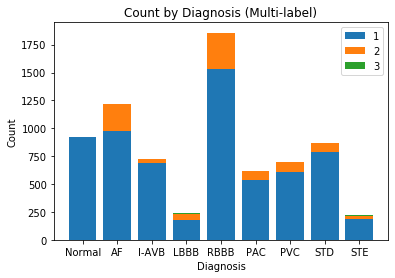

Multi-Label Occurences
           RBBB: (22.29%) 1533 records
             AF: (14.19%) 976 records
         Normal: (13.35%) 918 records
            STD: (11.40%) 784 records
          I-AVB: ( 9.98%) 686 records
            PVC: ( 8.83%) 607 records
            PAC: ( 7.75%) 533 records
            STE: ( 2.69%) 185 records
           LBBB: ( 2.60%) 179 records
       AF, RBBB: ( 2.50%) 172 records
      PAC, RBBB: ( 0.76%) 52 records
      PVC, RBBB: ( 0.74%) 51 records
        AF, STD: ( 0.44%) 30 records
       AF, LBBB: ( 0.38%) 26 records
      RBBB, STD: ( 0.29%) 20 records
       PVC, STD: ( 0.26%) 18 records
      RBBB, STE: ( 0.23%) 16 records
    I-AVB, RBBB: ( 0.15%) 10 records
      LBBB, PAC: ( 0.15%) 10 records
    I-AVB, LBBB: ( 0.12%) 8 records
        AF, PVC: ( 0.12%) 8 records
      LBBB, PVC: ( 0.09%) 6 records
       PAC, STD: ( 0.09%) 6 records
     I-AVB, STD: ( 0.09%) 6 records
     I-AVB, PVC: ( 0.07%) 5 records
     I-AVB, STE: ( 0.06%) 4 records
        AF,

In [10]:
plt.title("Count by Diagnosis (Multi-label)")
plt.xlabel("Diagnosis")
plt.ylabel("Count")

prv_count = [0,] * len(labels)
plts = {}
for i in range(1, len(labels)):
    nested_dx = [dx for m in metas.values() for dx in m.Dx if len(m.Dx) == i]
    if not nested_dx:
        continue
    dx_counter = Counter(nested_dx)
    count = list(dx_counter[l] for l in labels)
    plts[i] = plt.bar(labels, count, bottom=prv_count)
    prv_count = list(sum(c) for c in zip(prv_count, count))

plt.ylim(bottom, top)
plt.legend(plts.values(), plts.keys())
plt.show()

dx_counter = Counter([", ".join(sorted(m.Dx)) for m in metas.values()])
print("Multi-Label Occurences")
for key, count in sorted(dx_counter.items(), key=lambda i: i[1], reverse=True):
    pct = 100 * count / num_records
    print("{:>15}: ({:>5.2f}%) {} records".format(key, pct, count))


## WFDB QRS Detection Algorithms

The WFDB library provides helper processors (like [XQRS](https://wfdb.readthedocs.io/en/latest/processing.html#wfdb.processing.XQRS)) for generating annotations. 

In [11]:
wfdb.show_ann_labels()
wfdb.show_ann_classes()

    label_store symbol                                    description
0             0                              Not an actual annotation
1             1      N                                    Normal beat
2             2      L                  Left bundle branch block beat
3             3      R                 Right bundle branch block beat
4             4      a                Aberrated atrial premature beat
5             5      V              Premature ventricular contraction
6             6      F          Fusion of ventricular and normal beat
7             7      J              Nodal (junctional) premature beat
8             8      A                   Atrial premature contraction
9             9      S     Premature or ectopic supraventricular beat
10           10      E                        Ventricular escape beat
11           11      j                 Nodal (junctional) escape beat
12           12      /                                     Paced beat
13           13     

In [12]:
def xqrs_detect(record_name):
    sig_qrs_inds = []
    for channel in range(12):
        sig, fields = wfdb.rdsamp(record_name, channels=[channel])

        sig_qrs_inds.append(processing.xqrs_detect(
            sig=sig[:,0], sampfrom=0, sampto="end", fs=fields["fs"],
            learn=False, verbose=False))

    avg_sig_qrs_inds = np.array(
        [int(sum(e) / len(e)) for e in zip(
            *[a for a in sig_qrs_inds if len(a)])])
    return sig_qrs_inds, avg_sig_qrs_inds


In [13]:
record = wfdb.rdrecord(record_names[0])
sig_ann, sig_avg_ann = xqrs_detect(record_names[0])

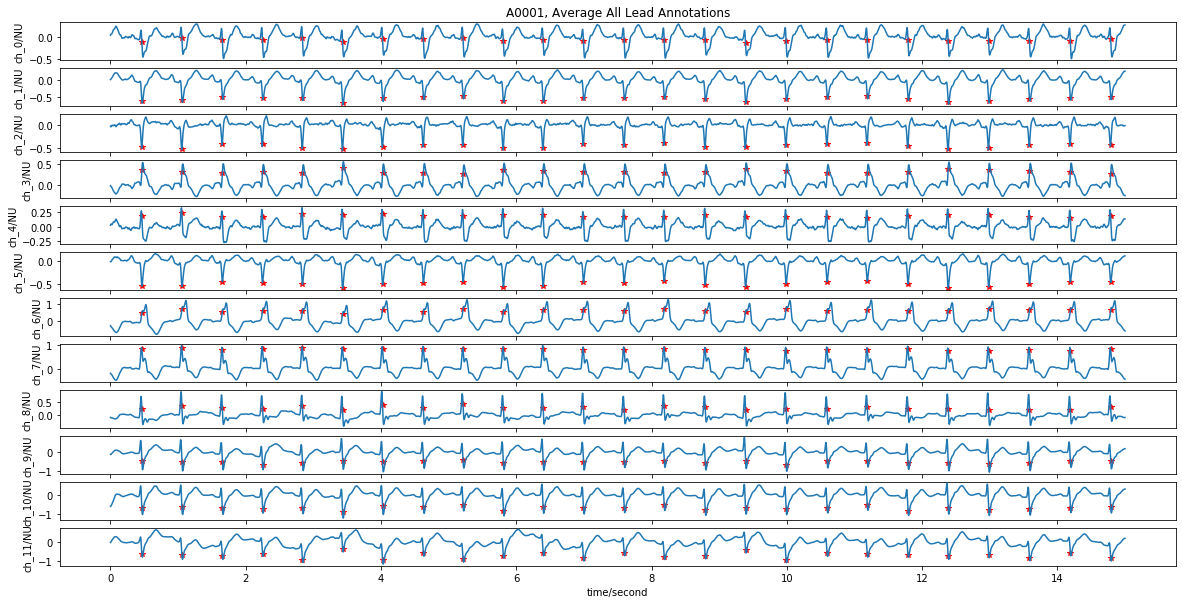

In [14]:
wfdb.plot_items(
    signal=record.p_signal,
    ann_samp=[sig_avg_ann,] * 12,
    fs = record.fs,
    time_units="seconds",
    figsize=(20,10),
    title="{}, Average All Lead Annotations".format(record.record_name))

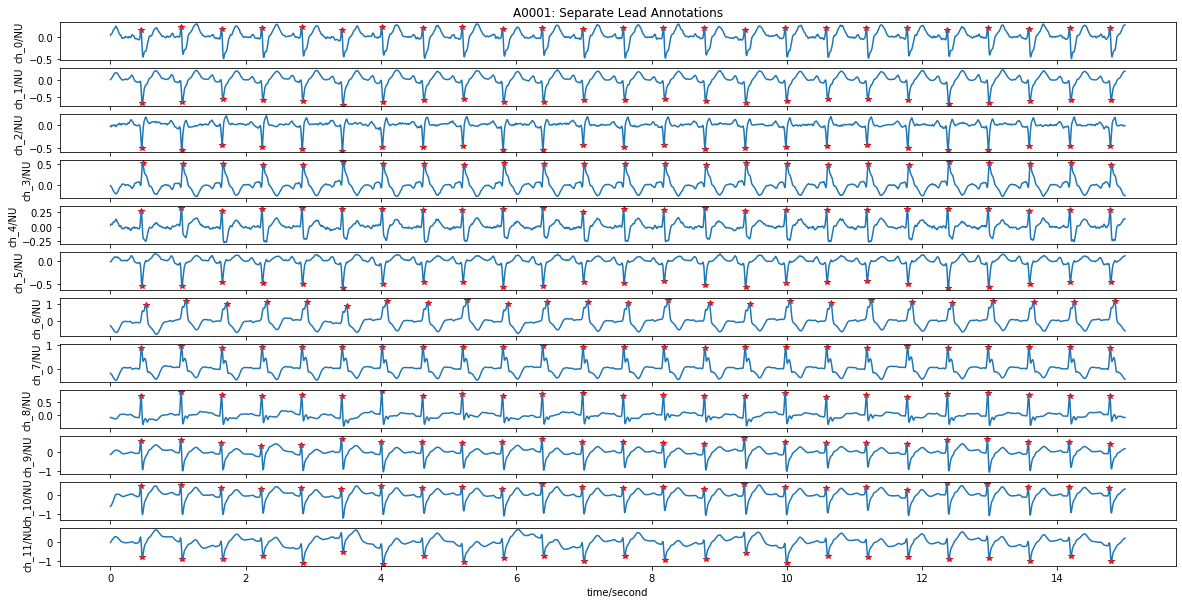

In [15]:
wfdb.plot_items(
    signal=record.p_signal,
    ann_samp=sig_ann,
    fs = record.fs,
    time_units="seconds",
    figsize=(20,10),
    title="{}: Separate Lead Annotations".format(record.record_name))

25 reference annotations, 25 test annotations

True Positives (matched samples): 25
False Positives (unmatched test samples: 0
False Negatives (unmatched reference samples): 0

Specificity: 1.0000 (25/25)
Positive Predictivity: 1.0000 (25/25)
False Positive Rate: 0.0000 (0/25)


/home/alexander/sandbox/src/git.udia.ca/alex/physionet-challenge-2020/venv/lib/python3.7/site-packages/wfdb/processing/evaluate.py:328: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


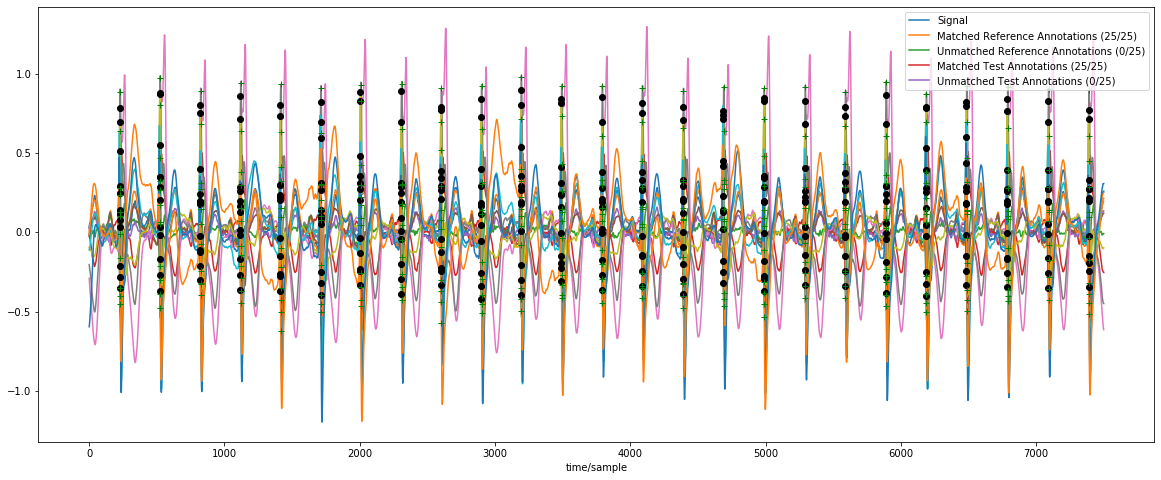

In [16]:
comparitor = processing.Comparitor(sig_ann[0], sig_ann[7], int(0.1 * record.fs), record.p_signal)
comparitor.compare()
comparitor.print_summary()
comparitor.plot(figsize=(20,8))

## Fourier Transformation

Applying the Fourier transformation on the ECG signals as a method of feature extraction


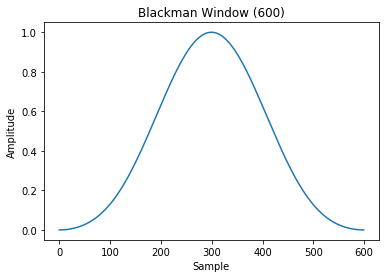

Text(0.5, 0, 'Normalized frequency [cycles per sample]')

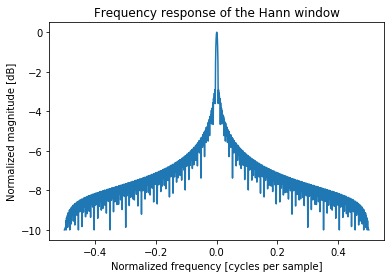

In [17]:
# Use a Hann window to ensure signal starts and ends with a zero
# scipy.signal.hann()

window = scipy.signal.blackman(600)
plt.figure()
plt.plot(window)
plt.title("Blackman Window (600)")
plt.ylabel("Amplitude")
plt.xlabel("Sample")
plt.show()

plt.figure()
fft_sig = scipy.fft(window, 1024) / (len(window) / 2.0)
freq = np.linspace(-0.5, 0.5, len(fft_sig))
response = np.abs(np.fft.fftshift(fft_sig / abs(fft_sig).max()))
response = np.log10(np.maximum(response, 1e-10))
plt.plot(freq, response)
# plt.axis([-0.5, 0.5, -120, 0])
plt.title("Frequency response of the Hann window")
plt.ylabel("Normalized magnitude [dB]")
plt.xlabel("Normalized frequency [cycles per sample]")


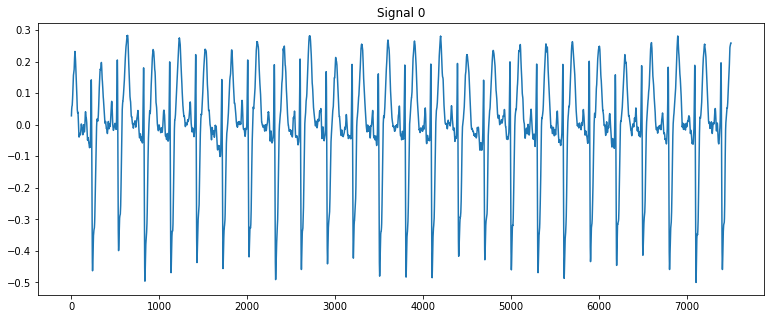

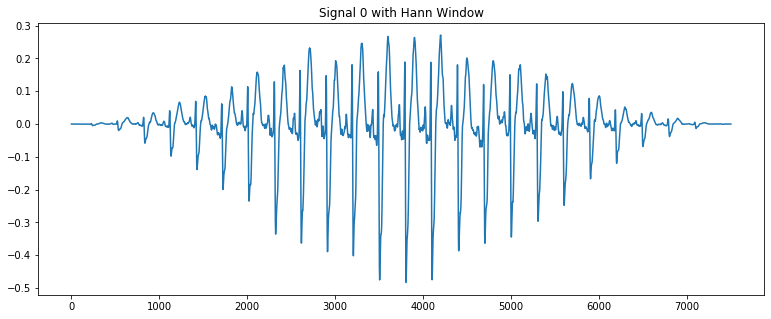

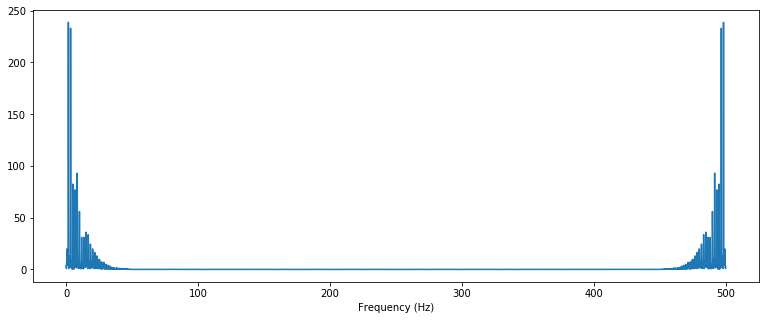

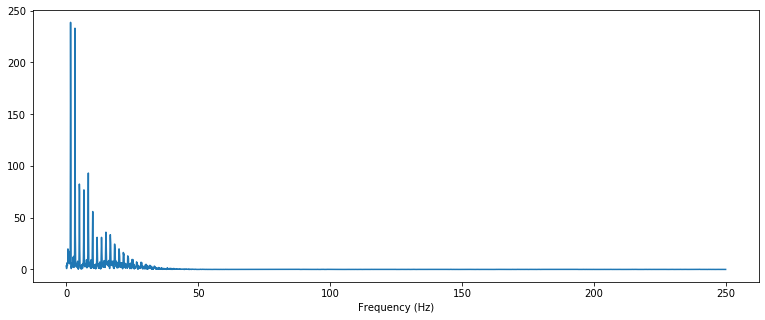

In [18]:
record = wfdb.rdrecord(record_names[0])

sig_0 = record.p_signal[:,0]

# Raw Signal
plt.figure(figsize=(13, 5))
plt.title("Signal 0")
plt.plot(sig_0)
plt.show()

# Signal MUST be windowed such that start and end is equal to zero
plt.figure(figsize=(13, 5))
plt.title("Signal 0 with Hann Window")
plt.plot(scipy.signal.hann(len(sig_0)) * (sig_0))
plt.show()

# Apply FFT on windowed signal
X = scipy.fft(scipy.signal.hann(len(sig_0)) * (sig_0))
X_mag = scipy.absolute(X)
f = np.linspace(0, record.fs, len(X_mag))

plt.figure(figsize=(13, 5))
plt.plot(f, X_mag)
plt.xlabel("Frequency (Hz)")
plt.show()

plt.figure(figsize=(13, 5))
plt.plot(f[:len(f)//2], X_mag[:len(X_mag)//2])
plt.xlabel("Frequency (Hz)")
plt.show()

3014
0.0005868098635401827


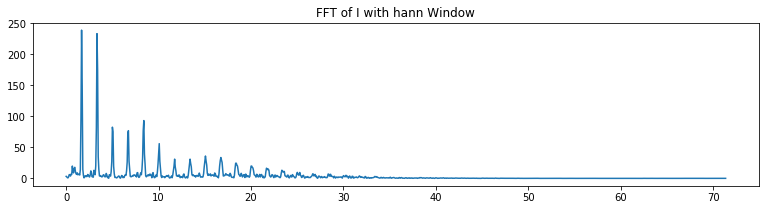

3454
0.0011645936416259906


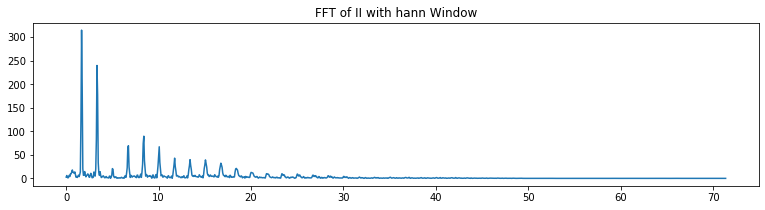

4925
0.0003900691801167088


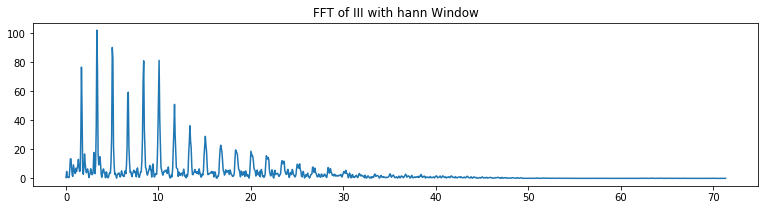

1854
0.0006115763032221221


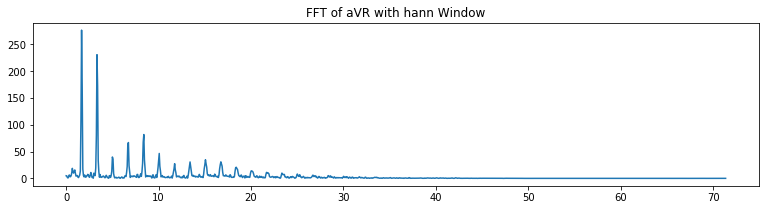

1193
0.0010994020586721806


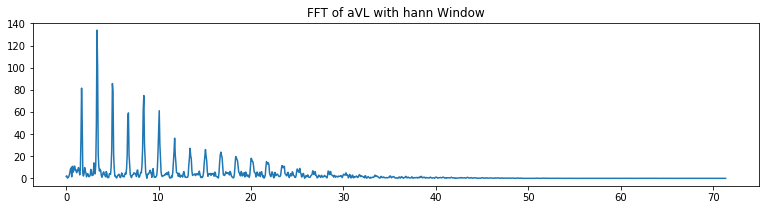

2888
0.00033142302599371485


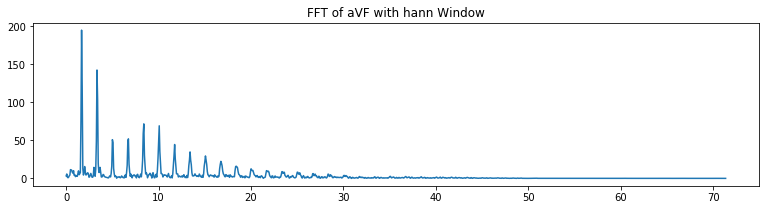

3896
0.00077594440355476


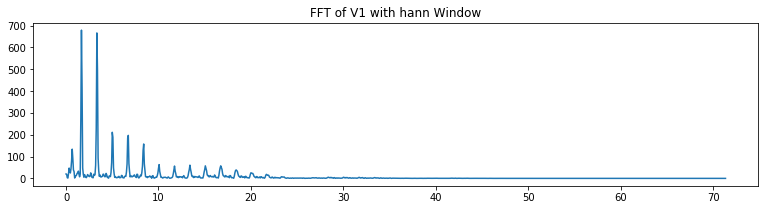

4977
0.000402030030722589


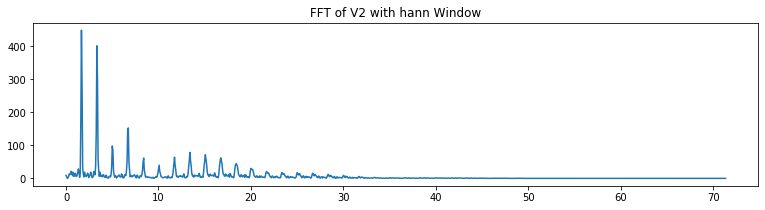

2796
0.00024649635760100785


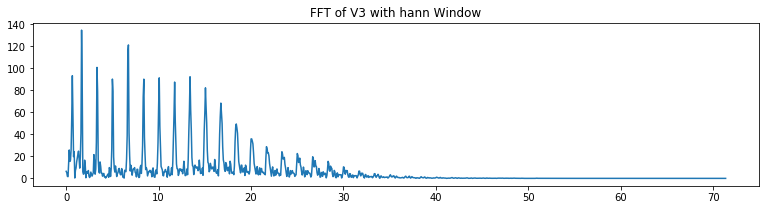

4354
0.000424560612199591


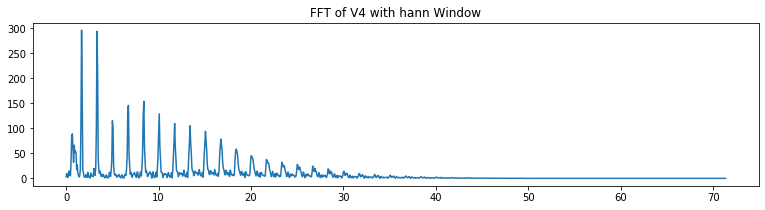

4976
0.0008579623746635877


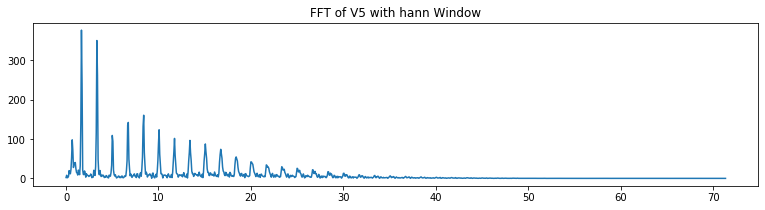

4374
4.139561947194935e-05


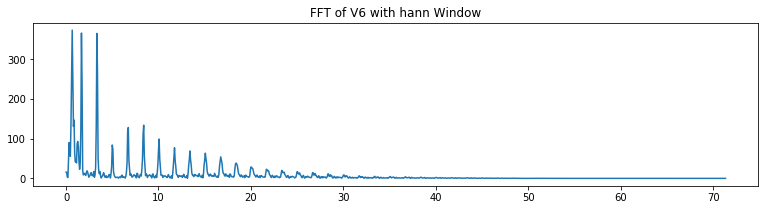

In [19]:
record = wfdb.rdrecord(record_names[0])
sig = record.p_signal
seq_len, num_leads = sig.shape

for lead_idx in range(num_leads):
    lead_sig = sig[:, lead_idx]
    sig_name = record.sig_name[lead_idx]

#     window = "hann"
#     window = "triang"
#     window = "blackman"
#     window = "hamming"
    window = "hann"
#     window = "bartlett"
#     window = "flattop"
#     window = "parzen"
#     window = "bohman"
#     window = "blackmanharris"
#     window = "nuttall"
#     window = "barthann"

    window_sig = scipy.signal.windows.get_window(window, len(lead_sig)) * lead_sig

    x = scipy.fft(window_sig)
    x_mag = scipy.absolute(x)
    f = np.linspace(0, 500, len(x_mag))

    print(np.argmin(x_mag))
    print(np.min(x_mag))
    

    plt.figure(figsize=(13, 3))
    plt.title(f"FFT of {sig_name} with {window} Window")
#     plt.plot(f[len(f)//8: 4 * len(f)//8], x_mag[len(x_mag)//8: 4 * len(x_mag)//8])
    plt.plot(f[0: len(f)//7], x_mag[0: len(x_mag)//7])

    plt.show()

## Biosppy ECG Feature Extraction

Visualizing feature extraction algorithms provided by the [biosppy](https://biosppy.readthedocs.io/en/stable/index.html) library.

In [20]:
def plot_ecg(ts=None,
             raw=None,
             filtered=None,
             rpeaks=None,
             templates_ts=None,
             templates=None,
             heart_rate_ts=None,
             heart_rate=None,
             name=None):

    MAJOR_LW = 2.5
    MINOR_LW = 1.5
    MAX_ROWS = 10
    
    fig = plt.figure(figsize=(12,6))
    fig.suptitle(name)
    gs = gridspec.GridSpec(6, 2)

    # raw signal
    ax1 = fig.add_subplot(gs[:2, 0])

    ax1.plot(ts, raw, linewidth=MAJOR_LW, label='Raw')

    ax1.set_ylabel('Amplitude')
    ax1.legend()
    ax1.grid()

    # filtered signal with rpeaks
    ax2 = fig.add_subplot(gs[2:4, 0], sharex=ax1)

    ymin = np.min(filtered)
    ymax = np.max(filtered)
    alpha = 0.1 * (ymax - ymin)
    ymax += alpha
    ymin -= alpha

    ax2.plot(ts, filtered, linewidth=MAJOR_LW, label='Filtered')
    ax2.vlines(ts[rpeaks], ymin, ymax,
               color='m',
               linewidth=MINOR_LW,
               label='R-peaks')

    ax2.set_ylabel('Amplitude')
    ax2.legend()
    ax2.grid()

    # heart rate
    ax3 = fig.add_subplot(gs[4:, 0], sharex=ax1)

    ax3.plot(heart_rate_ts, heart_rate, linewidth=MAJOR_LW, label='Heart Rate')

    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Heart Rate (bpm)')
    ax3.legend()
    ax3.grid()

    # templates
    ax4 = fig.add_subplot(gs[1:5, 1])

    ax4.plot(templates_ts, templates.T, 'm', linewidth=MINOR_LW, alpha=0.7)

    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Amplitude')
    ax4.set_title('Templates')
    ax4.grid()

    # make layout tight
    gs.tight_layout(fig)

    plt.show()


A0001


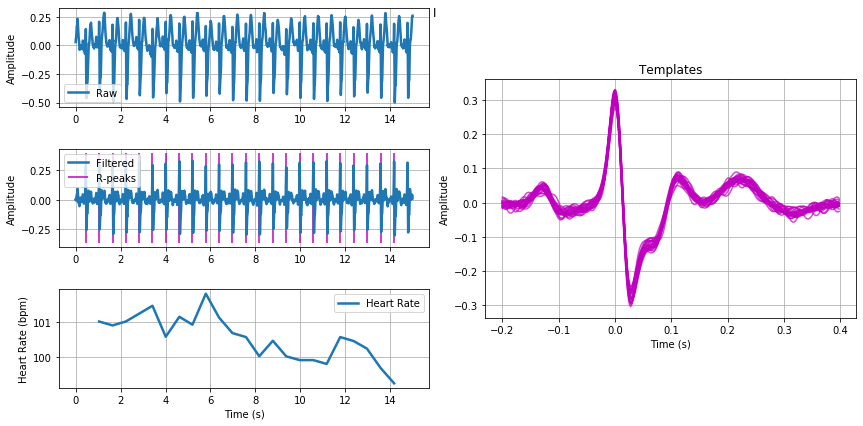

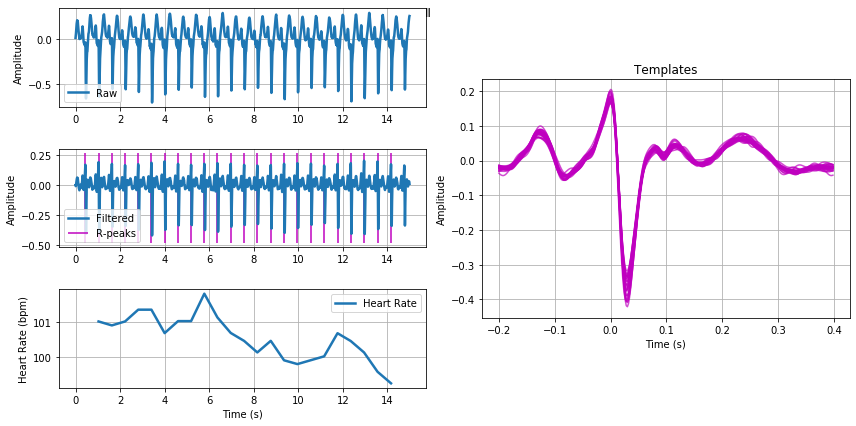

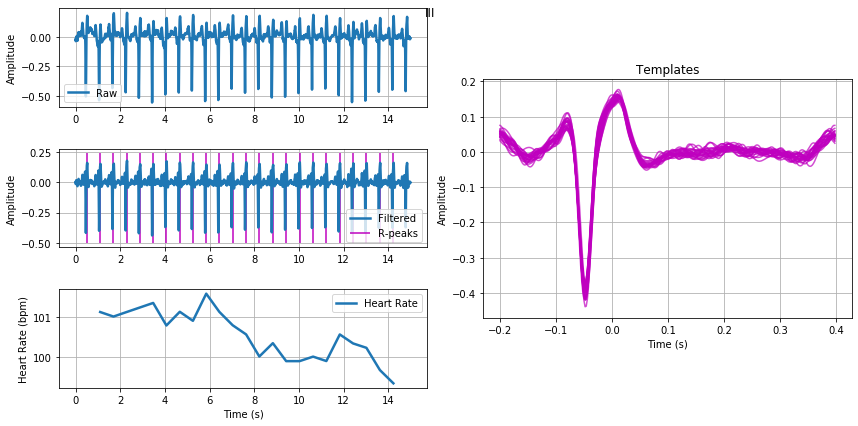

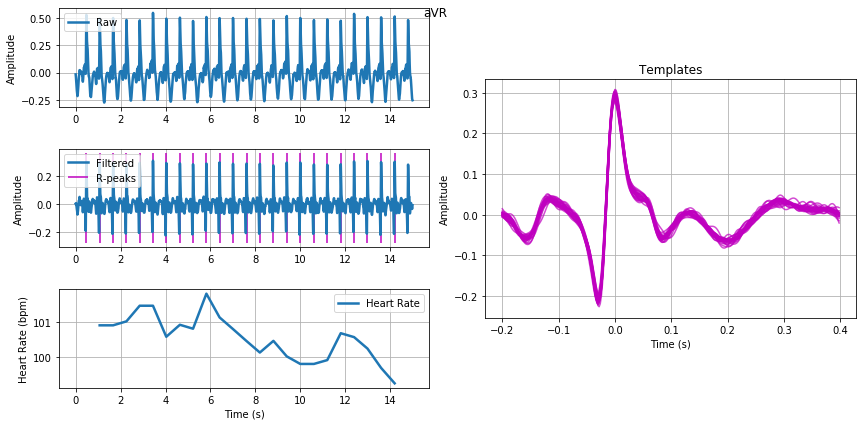

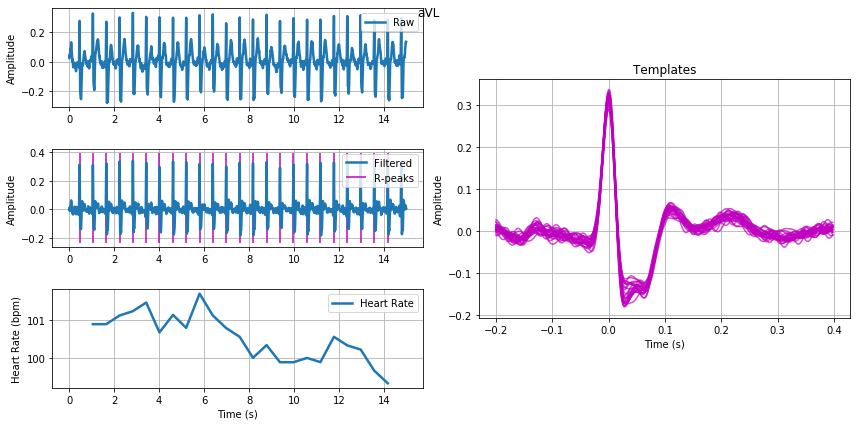

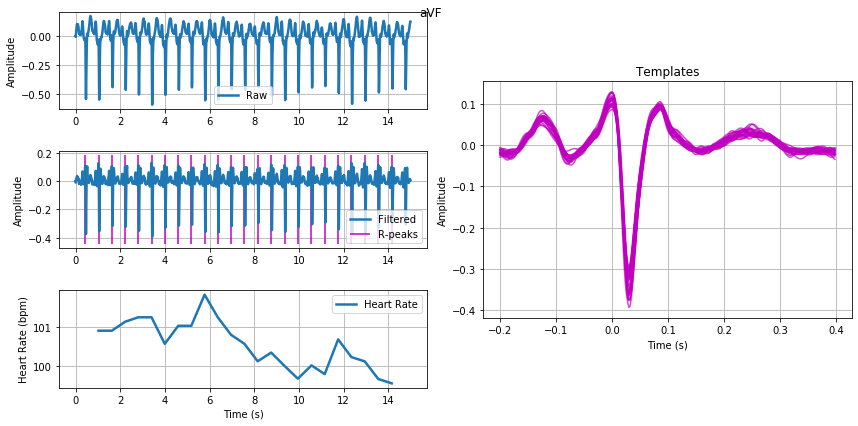

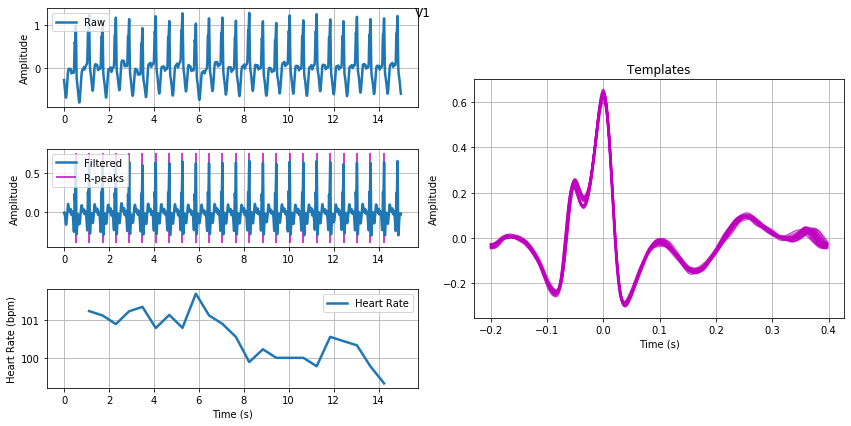

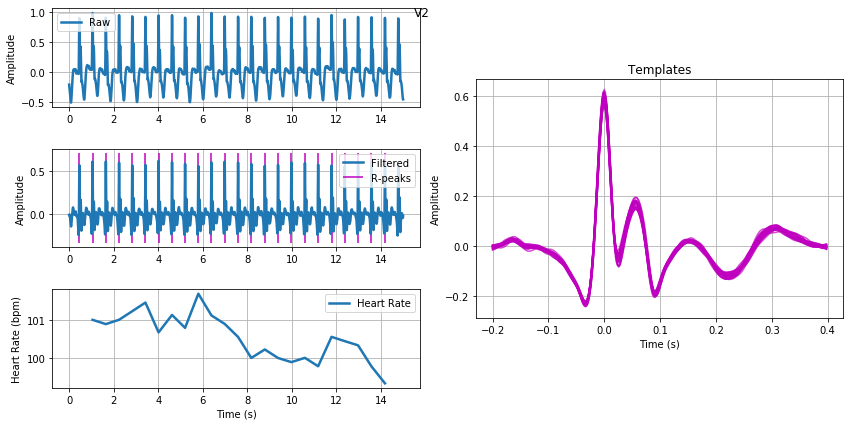

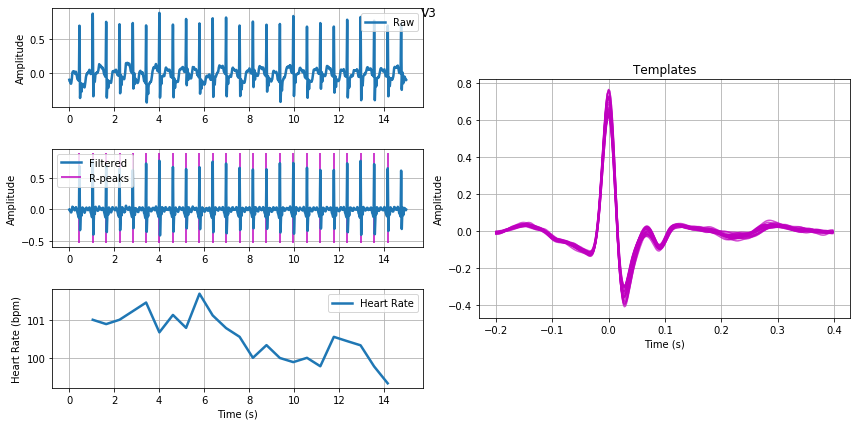

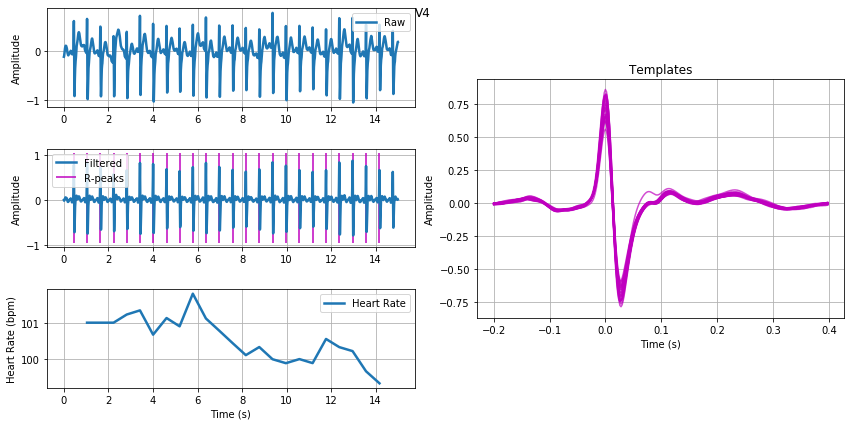

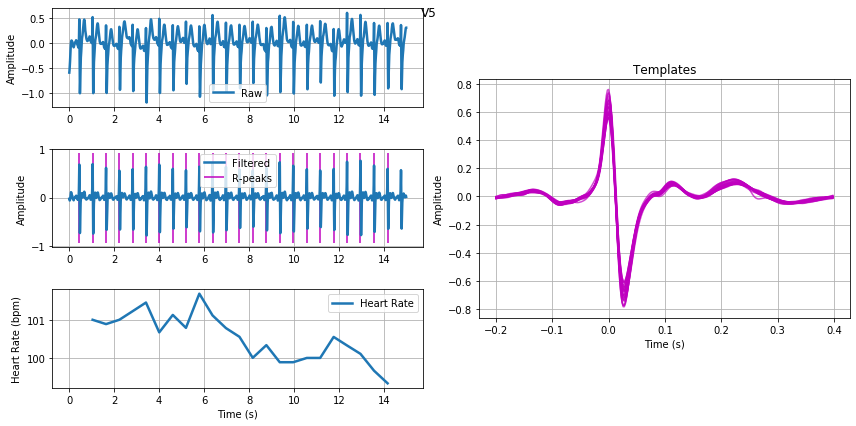

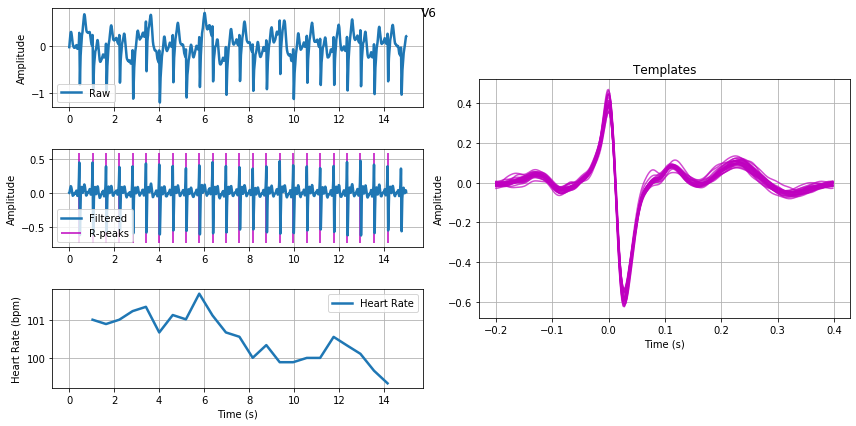

In [29]:
record = wfdb.rdrecord(record_names[0])
print(record.record_name)

summary = {}
for lead_idx in range(12):
    sig_name = record.sig_name[lead_idx]
    signal = record.p_signal[:,lead_idx]
    
    # Each signal must be processed separately
    features = dict(ecg(signal, sampling_rate=record.fs, show=False))
    plot_ecg(name=sig_name, raw=signal, **features)
    summary[sig_name] = dict(features, raw=signal)


In [30]:
# Extracted rpeaks count may not be consistent for all leads in the same ECG record (e.g. A0004)
for sig_name, features in summary.items():
    print(sig_name)
    for feature_name, feature in features.items():
        print(f"\t{feature_name}", feature.shape)

I
	ts (7500,)
	filtered (7500,)
	rpeaks (24,)
	templates_ts (300,)
	templates (24, 300)
	heart_rate_ts (23,)
	heart_rate (23,)
	raw (7500,)
II
	ts (7500,)
	filtered (7500,)
	rpeaks (24,)
	templates_ts (300,)
	templates (24, 300)
	heart_rate_ts (23,)
	heart_rate (23,)
	raw (7500,)
III
	ts (7500,)
	filtered (7500,)
	rpeaks (24,)
	templates_ts (300,)
	templates (24, 300)
	heart_rate_ts (23,)
	heart_rate (23,)
	raw (7500,)
aVR
	ts (7500,)
	filtered (7500,)
	rpeaks (24,)
	templates_ts (300,)
	templates (24, 300)
	heart_rate_ts (23,)
	heart_rate (23,)
	raw (7500,)
aVL
	ts (7500,)
	filtered (7500,)
	rpeaks (24,)
	templates_ts (300,)
	templates (24, 300)
	heart_rate_ts (23,)
	heart_rate (23,)
	raw (7500,)
aVF
	ts (7500,)
	filtered (7500,)
	rpeaks (24,)
	templates_ts (300,)
	templates (24, 300)
	heart_rate_ts (23,)
	heart_rate (23,)
	raw (7500,)
V1
	ts (7500,)
	filtered (7500,)
	rpeaks (24,)
	templates_ts (300,)
	templates (24, 300)
	heart_rate_ts (23,)
	heart_rate (23,)
	raw (7500,)
V2
	ts (75

### Consensus

Given slightly different R peaks from each lead, how do we combine them together meaningfully? Lists may not equal each other, so averaging them is out of the question.



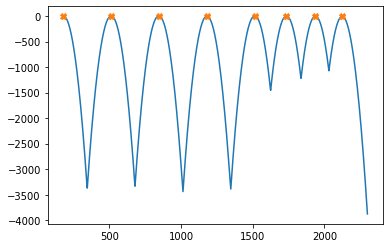

(178, 513, 845, 1181, 1513, 1735, 1937, 2123)


In [97]:
A = [ 178,  511,  843, 1180, 1512, 1733]
B = [ 514,  846, 1182, 1515, 1736, 1937]
C = [ 182,  516,  848, 1517, 1738, 1939]
D = [ 179,  513,  845, 1181, 1513, 1735, 1936, 2124]

from sklearn.neighbors import KernelDensity
from scipy.signal import find_peaks

concat = A + B + C + D
X = np.array(concat)[:, np.newaxis]

X_plot = np.linspace(X.min(), 2300, 2300)[:, np.newaxis]

kde = KernelDensity(bandwidth=2).fit(X)
log_dens = kde.score_samples(X_plot)
# dens = np.exp(log_dens)

peaks, _ = find_peaks(log_dens)

plt.plot(X_plot[:, 0], log_dens)
plt.plot(X_plot[peaks], log_dens[peaks], "X")

plt.show()

print(tuple(int(i) for i in X_plot[peaks].squeeze()))
